# 📱 TuniTech Advisor - ML Pipeline
## Complete Pipeline: Data → Features → Models → MLflow

**Authors:** Iheb Lamouchi & Yassine Nemri  
**Dataset:** 953 smartphones with prices from Tunisian e-commerce

---

## 📦 Step 1: Setup & Load Data

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
import time
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost
try:
    from xgboost import XGBRegressor
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "--quiet"])
    from xgboost import XGBRegressor

# MLflow
try:
    import mlflow
    import mlflow.sklearn
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "mlflow", "--quiet"])
    import mlflow
    import mlflow.sklearn

# Settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)  # For reproducibility

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
# Load data
df = pd.read_csv('../dataset/unified_smartphones_filled.csv')
df = df.dropna(subset=['price']).copy()  # Keep only phones with prices

print(f"📊 Dataset: {df.shape[0]} smartphones × {df.shape[1]} features")
print(f"💰 Price range: {df['price'].min():.0f} - {df['price'].max():.0f} TND")
df.head(3)

📊 Dataset: 953 smartphones × 14 features
💰 Price range: 159 - 8899 TND


,name,brand,ram_gb,storage_gb,battery_mah,screen_inches,camera_rear_mp,camera_front_mp,network,os,processor_type,price,url,source
0,Smartphone Lesia Young 1 | 2Go / 16Go | Vert,Lesia,4.0,16.0,2500.0,5.0,5.0,2.0,4G,Android 13,Quad Core,159.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
1,Smartphone Lesia Young 1 | 2Go / 16Go | Bleu,Lesia,4.0,16.0,2500.0,5.0,5.0,2.0,4G,Android 13,Quad Core,159.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
2,Smartphone Lesia Young 6 4Go /16Go - Noir,Lesia,4.0,16.0,3000.0,6.0,5.0,2.0,3G,Android 13,Octa Core,179.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet


## 🔧 Step 2: Feature Engineering

In [3]:
# Normalize specs to 0-1 scale for value calculations
numerical_cols = ['ram_gb', 'storage_gb', 'battery_mah', 'screen_inches', 'camera_rear_mp', 'camera_front_mp']
scaler_temp = MinMaxScaler()
df_normalized = pd.DataFrame(
    scaler_temp.fit_transform(df[numerical_cols]),
    columns=numerical_cols,
    index=df.index
)

# Create engineered features
df['specs_sum_normalized'] = df_normalized.mean(axis=1)
df['value_score'] = df['specs_sum_normalized'] / (df['price'] / 1000)
df['total_specs_score'] = (
    df_normalized['ram_gb'] * 0.25 +
    df_normalized['storage_gb'] * 0.25 +
    df_normalized['battery_mah'] * 0.15 +
    df_normalized['camera_rear_mp'] * 0.20 +
    df_normalized['camera_front_mp'] * 0.10 +
    df_normalized['screen_inches'] * 0.05
)
df['price_tier'] = pd.cut(df['price'], bins=[0, 700, 2000, float('inf')], labels=['Budget', 'Mid-Range', 'Premium'])

print("✅ Engineered Features Created:")
print(f"   - value_score: Best value phones")
print(f"   - total_specs_score: Overall quality")
print(f"   - price_tier: {df['price_tier'].value_counts().to_dict()}")

✅ Engineered Features Created:
   - value_score: Best value phones
   - total_specs_score: Overall quality
   - price_tier: {'Budget': 592, 'Mid-Range': 223, 'Premium': 138}


## 🎯 Step 3: Feature Selection & Data Split

In [4]:
# Define selected features (based on importance analysis)
SELECTED_NUMERICAL = ['value_score', 'total_specs_score']
SELECTED_CATEGORICAL = ['brand', 'network', 'os', 'processor_type', 'price_tier']

# Prepare features and target
X = df[SELECTED_NUMERICAL + SELECTED_CATEGORICAL].copy()
y = df['price'].copy()

# Train/Test Split (80/20) - DO NOT RE-RUN THIS CELL TO MAINTAIN CONSISTENCY
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"📊 Selected Features: {len(SELECTED_NUMERICAL) + len(SELECTED_CATEGORICAL)}")
print(f"   Numerical: {SELECTED_NUMERICAL}")
print(f"   Categorical: {SELECTED_CATEGORICAL}")
print(f"\n📊 Data Split:")
print(f"   Train: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Save splits for reproducibility
os.makedirs('../models', exist_ok=True)
with open('../models/data_splits.pkl', 'wb') as f:
    pickle.dump({'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}, f)
print("\n✅ Data splits saved to models/data_splits.pkl")

📊 Selected Features: 7
   Numerical: ['value_score', 'total_specs_score']
   Categorical: ['brand', 'network', 'os', 'processor_type', 'price_tier']

📊 Data Split:
   Train: 762 samples (80.0%)
   Test: 191 samples (20.0%)

✅ Data splits saved to models/data_splits.pkl


## 🤖 Step 4: Build Preprocessing Pipeline

In [5]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler())
    ]), SELECTED_NUMERICAL),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ]), SELECTED_CATEGORICAL)
])

print("✅ Preprocessing pipeline created")
print("   Numerical: KNNImputer → StandardScaler")
print("   Categorical: SimpleImputer → OneHotEncoder")

✅ Preprocessing pipeline created
   Numerical: KNNImputer → StandardScaler
   Categorical: SimpleImputer → OneHotEncoder


## 📈 Step 5: MLflow Setup

In [6]:
# Setup MLflow
mlruns_path = os.path.join('..', 'mlruns')
os.makedirs(mlruns_path, exist_ok=True)
mlflow.set_tracking_uri(f"file:///{os.path.abspath(mlruns_path)}")
mlflow.set_experiment("TuniTech_Smartphone_Recommender")

print(f"✅ MLflow tracking ready")
print(f"📁 Location: {os.path.abspath(mlruns_path)}")
print(f"🚀 Launch UI: mlflow ui --backend-store-uri file:///{os.path.abspath(mlruns_path)}")

✅ MLflow tracking ready
📁 Location: c:\Users\ihebl\Downloads\projet python sem 2\projet python sem 2\mlruns
🚀 Launch UI: mlflow ui --backend-store-uri file:///c:\Users\ihebl\Downloads\projet python sem 2\projet python sem 2\mlruns


## 🎯 Step 6: Train & Compare Models with MLflow

In [7]:
# Function to train and evaluate model with MLflow
def train_model_with_mlflow(model, model_name, params, run_name=None):
    """
    Train a model with MLflow tracking
    
    Args:
        model: sklearn model instance
        model_name: Name of model type
        params: Dictionary of parameters to log
        run_name: Optional custom run name
    
    Returns:
        pipeline: Trained pipeline
        metrics: Performance metrics dict
    """
    with mlflow.start_run(run_name=run_name or model_name):
        # Log tags
        mlflow.set_tag("model_type", model_name)
        mlflow.set_tag("dataset_size", len(X_train))
        
        # Log parameters
        for key, value in params.items():
            mlflow.log_param(key, value)
        
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Train
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Predict
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Log metrics
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2_score", r2)
        mlflow.log_metric("training_time", training_time)
        
        # Log model
        mlflow.sklearn.log_model(pipeline, "model")
        
        metrics = {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'training_time': training_time
        }
        
        print(f"✅ {model_name}: MAE={mae:.2f} TND | R²={r2:.4f} | Time={training_time:.3f}s")
        
        return pipeline, metrics

print("✅ Training function ready")

✅ Training function ready


In [8]:
# Train all models
print("🚀 Training Models...\n")

models_results = {}

# 1. KNN
knn_model = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_pipeline, knn_metrics = train_model_with_mlflow(
    knn_model, "KNN", 
    {'n_neighbors': 5, 'weights': 'distance'},
    "KNN_n5"
)
models_results['KNN_n5'] = knn_metrics

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_pipeline, rf_metrics = train_model_with_mlflow(
    rf_model, "Random Forest",
    {'n_estimators': 100, 'max_depth': 20, 'random_state': 42},
    "Random_Forest"
)
models_results['Random_Forest'] = rf_metrics

# 3. XGBoost
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_pipeline, xgb_metrics = train_model_with_mlflow(
    xgb_model, "XGBoost",
    {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'random_state': 42},
    "XGBoost"
)
models_results['XGBoost'] = xgb_metrics

print("\n✅ All baseline models trained!")

🚀 Training Models...



2026/02/17 13:38:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ KNN: MAE=9.20 TND | R²=0.9995 | Time=0.010s


2026/02/17 13:38:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Random Forest: MAE=24.36 TND | R²=0.9970 | Time=0.116s


2026/02/17 13:38:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ XGBoost: MAE=18.15 TND | R²=0.9984 | Time=0.197s

✅ All baseline models trained!


## 🔬 Step 7: Hyperparameter Tuning (KNN)

In [9]:
# Test different n_neighbors for KNN
print("🔬 Hyperparameter Tuning: KNN n_neighbors...\n")

for n in [3, 7, 10, 15]:
    knn = KNeighborsRegressor(n_neighbors=n, weights='distance')
    mlflow.set_experiment("TuniTech_Smartphone_Recommender")
    pipe, metrics = train_model_with_mlflow(
        knn, "KNN",
        {'n_neighbors': n, 'weights': 'distance'},
        f"KNN_n{n}"
    )
    models_results[f'KNN_n{n}'] = metrics

print("\n✅ Hyperparameter tuning complete!")

2026/02/17 13:38:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🔬 Hyperparameter Tuning: KNN n_neighbors...



2026/02/17 13:39:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ KNN: MAE=15.58 TND | R²=0.9972 | Time=0.008s


2026/02/17 13:39:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ KNN: MAE=11.95 TND | R²=0.9989 | Time=0.009s


2026/02/17 13:39:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ KNN: MAE=14.01 TND | R²=0.9980 | Time=0.008s
✅ KNN: MAE=17.07 TND | R²=0.9961 | Time=0.009s

✅ Hyperparameter tuning complete!


## 📊 Step 8: Compare All Models

In [10]:
# Create comparison table
comparison_df = pd.DataFrame(models_results).T
comparison_df = comparison_df.sort_values('mae')

print("=" * 80)
print("MODEL COMPARISON (Test Set Performance)")
print("=" * 80)
print(comparison_df.to_string())
print("=" * 80)

# Find best model
best_model_name = comparison_df.index[0]
best_mae = comparison_df.iloc[0]['mae']
best_r2 = comparison_df.iloc[0]['r2']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   MAE: {best_mae:.2f} TND")
print(f"   R²: {best_r2:.4f}")
print("=" * 80)

MODEL COMPARISON (Test Set Performance)
                     mae       rmse        r2  training_time
KNN_n5          9.203328  32.209779  0.999540       0.010240
KNN_n7         11.953991  49.804861  0.998901       0.008644
KNN_n10        14.009275  67.866989  0.997959       0.007828
KNN_n3         15.575204  80.075064  0.997159       0.008481
KNN_n15        17.074803  94.191093  0.996069       0.008741
XGBoost        18.145578  60.933067  0.998355       0.197351
Random_Forest  24.358953  82.503917  0.996984       0.115840

🏆 BEST MODEL: KNN_n5
   MAE: 9.20 TND
   R²: 0.9995


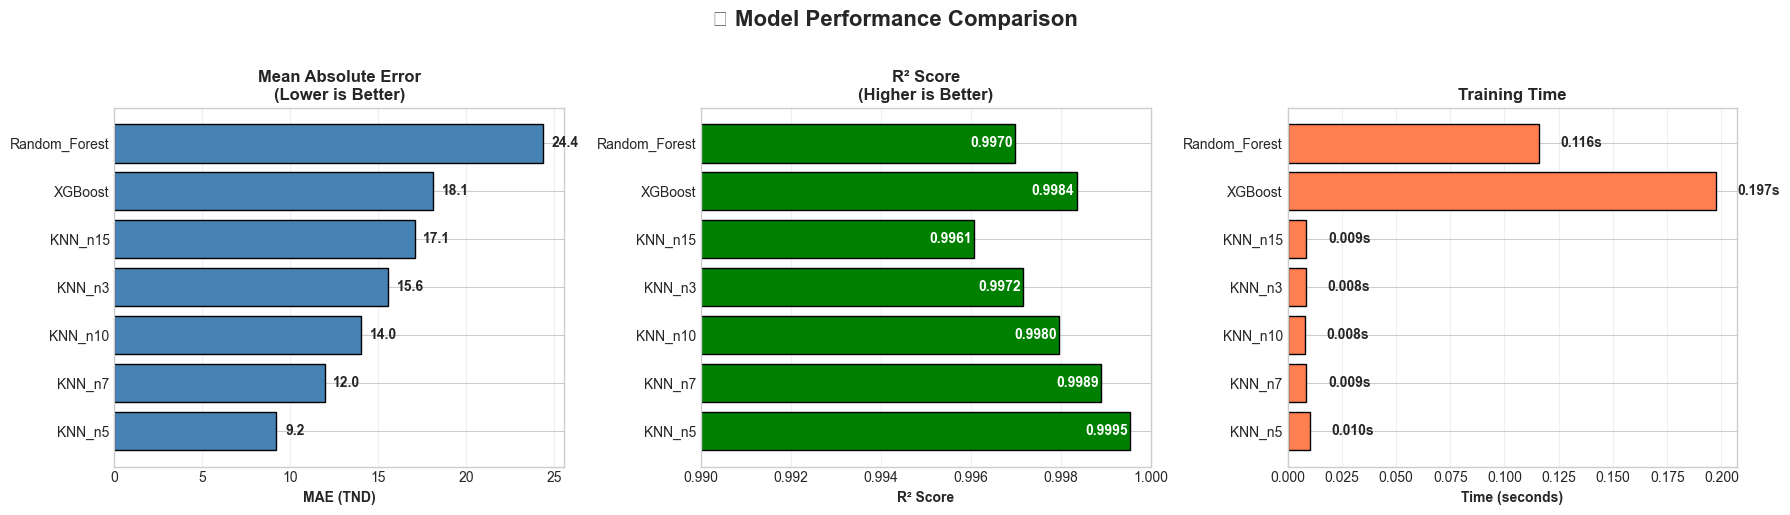

✅ Chart saved: models/model_comparison.png


In [11]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE
axes[0].barh(comparison_df.index, comparison_df['mae'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('MAE (TND)', fontweight='bold')
axes[0].set_title('Mean Absolute Error\n(Lower is Better)', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(comparison_df['mae']):
    axes[0].text(v + 0.5, i, f'{v:.1f}', va='center', fontweight='bold')

# R²
axes[1].barh(comparison_df.index, comparison_df['r2'], color='green', edgecolor='black')
axes[1].set_xlabel('R² Score', fontweight='bold')
axes[1].set_title('R² Score\n(Higher is Better)', fontweight='bold')
axes[1].set_xlim([0.99, 1.0])
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(comparison_df['r2']):
    axes[1].text(v - 0.001, i, f'{v:.4f}', va='center', fontweight='bold', color='white')

# Training Time
axes[2].barh(comparison_df.index, comparison_df['training_time'], color='coral', edgecolor='black')
axes[2].set_xlabel('Time (seconds)', fontweight='bold')
axes[2].set_title('Training Time', fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)
for i, v in enumerate(comparison_df['training_time']):
    axes[2].text(v + 0.01, i, f'{v:.3f}s', va='center', fontweight='bold')

plt.suptitle('🏆 Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../models/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Chart saved: models/model_comparison.png")

## 💾 Step 9: Save Best Model

In [12]:
# Train the best model configuration one final time and save it
if 'KNN' in best_model_name:
    # Extract n_neighbors from name (e.g., "KNN_n10" -> 10)
    n_value = int(best_model_name.split('_n')[1]) if '_n' in best_model_name else 5
    final_model = KNeighborsRegressor(n_neighbors=n_value, weights='distance')
    print(f"🏆 Best model: KNN with n_neighbors={n_value}")
elif 'Random' in best_model_name:
    final_model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
    print(f"🏆 Best model: Random Forest")
else:
    final_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
    print(f"🏆 Best model: XGBoost")

# Create final pipeline
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', final_model)
])

# Train on full training set
best_pipeline.fit(X_train, y_train)

# Save the best model
with open('../models/best_model.pkl', 'wb') as f:
    pickle.dump(best_pipeline, f)

# Save model info
model_info = {
    'model_name': best_model_name,
    'mae': best_mae,
    'r2': best_r2,
    'features': SELECTED_NUMERICAL + SELECTED_CATEGORICAL,
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

with open('../models/best_model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print(f"\n✅ Best model saved: models/best_model.pkl")
print(f"✅ Model info saved: models/best_model_info.pkl")
print(f"\n📊 Final Performance:")
print(f"   MAE: {best_mae:.2f} TND (avg error per prediction)")
print(f"   R²: {best_r2:.4f} (explains {best_r2*100:.2f}% of variance)")

🏆 Best model: KNN with n_neighbors=5

✅ Best model saved: models/best_model.pkl
✅ Model info saved: models/best_model_info.pkl

📊 Final Performance:
   MAE: 9.20 TND (avg error per prediction)
   R²: 0.9995 (explains 99.95% of variance)


## 🎯 Step 10: MLflow Summary

In [13]:
# Get MLflow experiment summary
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiment = mlflow.get_experiment_by_name("TuniTech_Smartphone_Recommender")
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Display summary
runs_summary = runs[['tags.model_type', 'metrics.mae', 'metrics.rmse', 'metrics.r2_score']].copy()
runs_summary.columns = ['Model', 'MAE (TND)', 'RMSE (TND)', 'R²']
runs_summary = runs_summary.dropna().sort_values('MAE (TND)')

print("=" * 80)
print("MLFLOW EXPERIMENT SUMMARY")
print("=" * 80)
print(runs_summary.to_string(index=False))
print("=" * 80)
print(f"\n📊 Total runs logged: {len(runs)}")
print(f"🏆 Best MAE: {runs_summary.iloc[0]['MAE (TND)']:.2f} TND")
print(f"\n🚀 View in MLflow UI:")
print(f"   mlflow ui --backend-store-uri file:///{os.path.abspath(mlruns_path)}")
print(f"   Then open: http://localhost:5000")

MLFLOW EXPERIMENT SUMMARY
        Model  MAE (TND)  RMSE (TND)       R²
          KNN   4.423766   19.071458 0.999839
          KNN   6.196485   35.667511 0.999436
          KNN   7.968689   52.059818 0.998799
          KNN   9.203328   32.209779 0.999540
          KNN  11.953991   49.804861 0.998901
          KNN  12.223613   76.403865 0.997414
          KNN  12.733658   57.462433 0.998537
          KNN  14.009275   67.866989 0.997959
          KNN  14.978139   86.581127 0.996679
          KNN  15.575204   80.075064 0.997159
          KNN  16.380369   71.932296 0.997708
      XGBoost  17.049947   45.209149 0.999094
          KNN  17.074803   94.191093 0.996069
      XGBoost  17.273490   44.874491 0.999108
      XGBoost  18.145578   60.933067 0.998355
          KNN  18.159005  115.009898 0.994140
Random Forest  20.752812   52.826007 0.998764
Random Forest  21.288785   55.901898 0.998615
Random Forest  24.358953   82.503917 0.996984

📊 Total runs logged: 20
🏆 Best MAE: 4.42 TND

🚀 View 

---
## ✅ Pipeline Complete!

### Summary:
- ✅ **Data Loaded**: 953 smartphones with prices
- ✅ **Features Engineered**: value_score, total_specs_score, price_tier
- ✅ **Models Trained**: KNN (multiple configs), Random Forest, XGBoost
- ✅ **MLflow Tracking**: All experiments logged with parameters & metrics
- ✅ **Best Model Saved**: Ready for deployment

### Files Created:
- `models/best_model.pkl` - Production-ready model
- `models/best_model_info.pkl` - Model metadata
- `models/data_splits.pkl` - Train/test splits for reproducibility
- `models/model_comparison.png` - Performance visualization
- `mlruns/` - MLflow tracking data

### Next Steps:
1. Launch MLflow UI to explore all experiments
2. Compare models visually in MLflow
3. Use `best_model.pkl` for predictions/deployment
4. Continue to Week 3: FastAPI Backend Development